In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d trolukovich/food11-image-dataset

food11-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
with zipfile.ZipFile('/content/food11-image-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('path/to/extract')

In [ ]:
# import the necessary packages
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import random
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from random import sample

In [ ]:
train = {}
test = {}

path = "/content/path/to/extract"

# Make dictionary storing images for each category under train data.
path_train = os.path.join(path, "training")
for i in os.listdir(path_train):
    train[i] = os.listdir(os.path.join(path_train, i))

# Make dictionary storing images for each category under test data.
path_test = os.path.join(path, "validation")
for i in os.listdir(path_test):
    test[i] = os.listdir(os.path.join(path_test, i))

In [ ]:
# View the number of images in the entire training and testing datasets respectively.
len_train = np.concatenate(list(train.values())).shape[0]
len_test = np.concatenate(list(test.values())).shape[0]

print("Number of images in training data : {}".format(len_train))
print("Number of images in testing data : {}".format(len_test))

Number of images in training data : 9866
Number of images in testing data : 3430


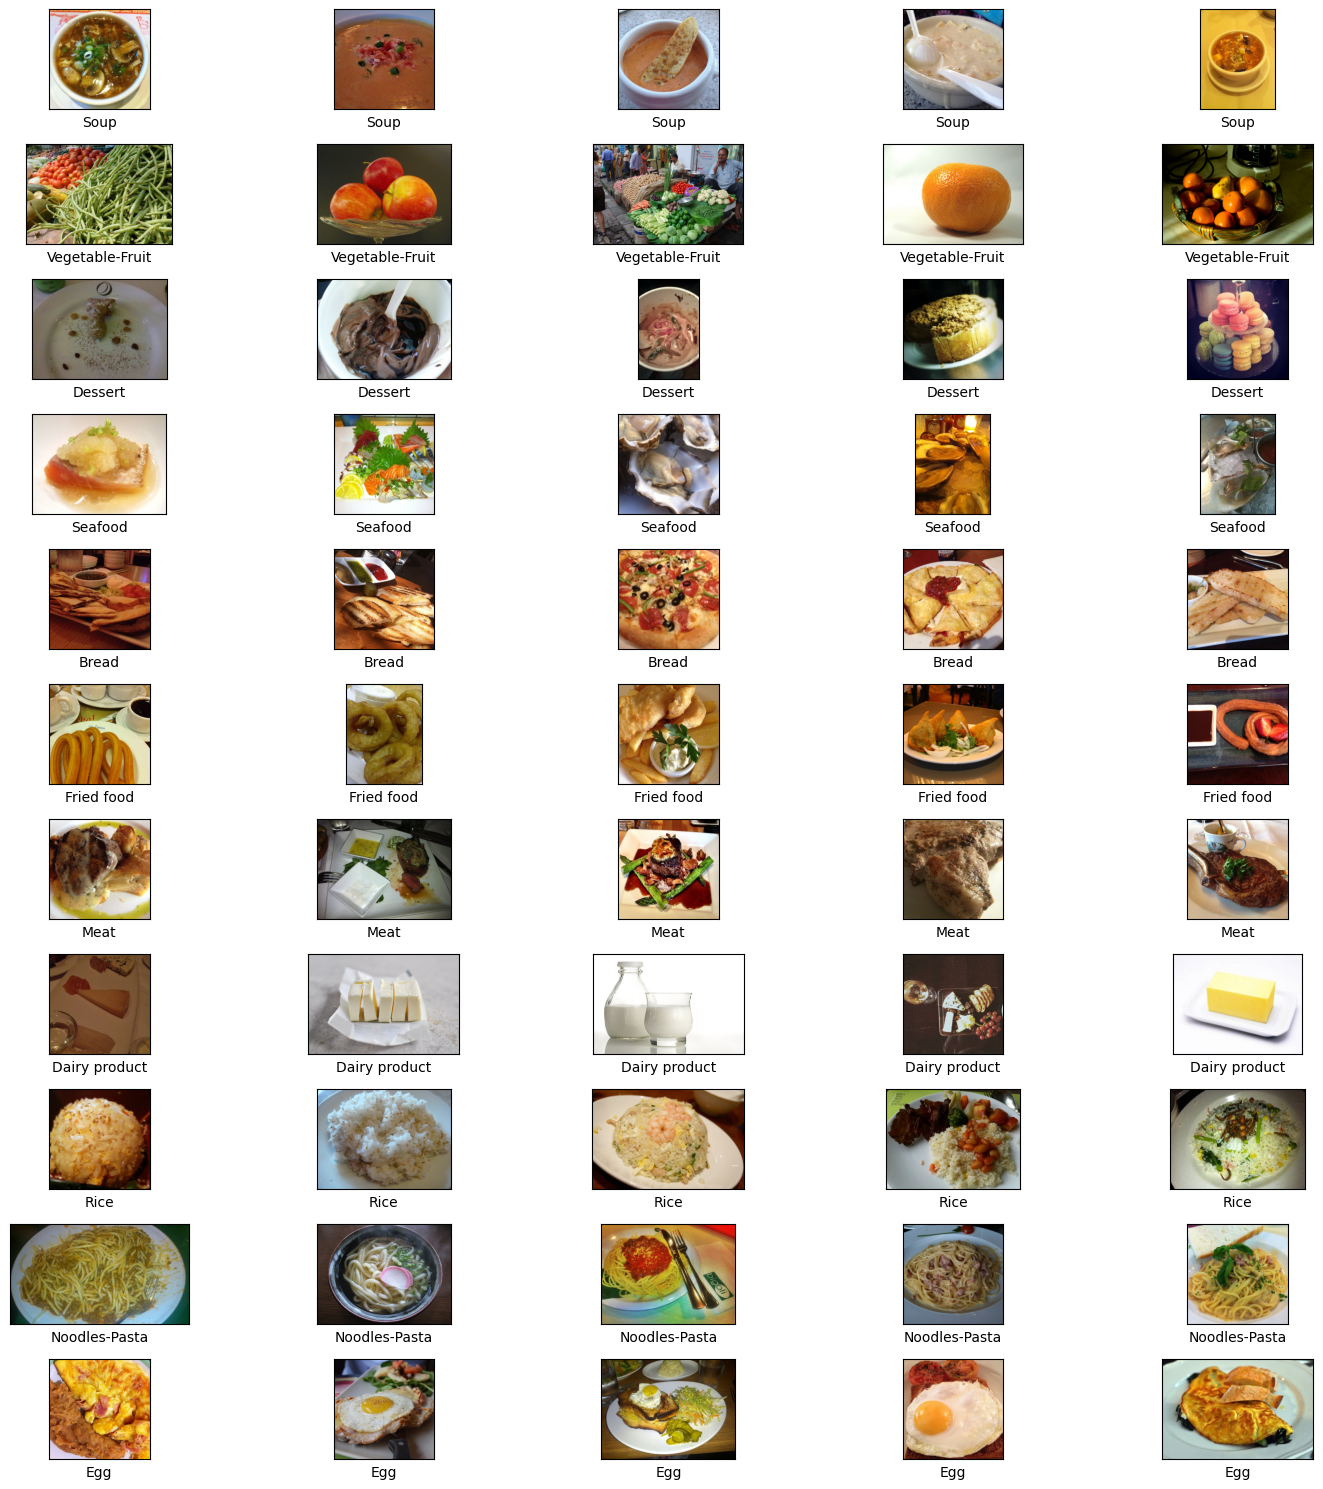

In [ ]:
# Randomly display 5 images under each of the 6 categories from the training data.
# You will see different images each time.
fig, axs = plt.subplots(len(train.keys()), 5, figsize = (15, 15))
for i, item in enumerate(os.listdir(path_train)):
    images = sample(train[item], 5)

    for j, image in enumerate(images):
        img = PIL.Image.open(os.path.join(path_train, item, image))
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel = item, xticks = [], yticks = [])

fig.tight_layout()

In [ ]:
# View the number of images in each of the 6 categories in the training data.
for item in train.keys():
    print(item, len(train[item]))

Soup 1500
Vegetable-Fruit 709
Dessert 1500
Seafood 855
Bread 994
Fried food 848
Meat 1325
Dairy product 429
Rice 280
Noodles-Pasta 440
Egg 986


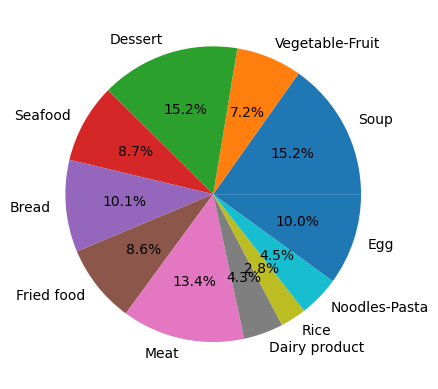

In [ ]:
# Make a pie-chart to visualize the percentage contribution of each category.
# This is often useful when you want your dataset to be balanced.
fig, ax = plt.subplots()
ax.pie(
    [len(train[item]) for item in train],
    labels = train.keys(),
    autopct = "%1.1f%%"
)
fig.show()

In [ ]:
# Create an Image Generator and specify the type of data augmentation you want to apply.
# Here we go with zooming, flipping (horizontally and vertically), and rescaling.
train_datagen = ImageDataGenerator(
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    rescale=1./255
)

# For test data we only rescale the data.
# Never augment test data!!!
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Create a generator for the images.
# This will make images (including augmented ones) start flowing from the directory to the model.
# Note that augmented images are not stored along with the original images. The process happens in memory.

# Train generator
train_generator = train_datagen.flow_from_directory(
    path_train,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    path_test,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.


In [ ]:
# Load the inception resnetv2 model
basemodel = InceptionResNetV2(
    weights = "imagenet",
    include_top = False, # Classification layer (output layer- sigmoid activations)
    input_tensor = Input((256, 256, 3))
)

219055592/219055592 [==============================] - 1s 0us/step


In [ ]:
# print the model summary
basemodel.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 127, 127, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 127, 127, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 127, 127, 32)         0         ['batch_norm

In [ ]:
# Freeze the basemodel weights, so these weights won't change during training
basemodel.trainable = False

In [ ]:
# Add classification head to the model
headmodel = basemodel.output
headmodel = GlobalAveragePooling2D(name = "Global_Average_Pool")(headmodel)
headmodel = Flatten(name = "flatten")(headmodel)
headmodel = Dense(256, activation = "relu", name = "dense_1")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = "relu", name = "dense_2")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(11, activation = "softmax", name = "output")(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
# Compile the model
model.compile(
    loss = "categorical_crossentropy",
    optimizer = SGD(
        lr = 0.01,
        momentum = 0.9
    ),
    metrics = ["accuracy"]
)

In [ ]:
# Using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(
    monitor = 'loss',
    verbose = 1,
    patience = 20
)

# save the best model with lower loss
checkpointer = ModelCheckpoint(
    filepath = "weights.hdf5",
    verbose = 1,
    save_best_only = True
)

In [ ]:
# Finally, fit the neural network model to the data.
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.n // 32,
    epochs = 1,
    callbacks = [checkpointer, earlystopping]
)

308/308 [==============================] - ETA: 0s - loss: 1.1779 - accuracy: 0.6193 

308/308 [==============================] - 3770s 12s/step - loss: 1.1779 - accuracy: 0.6193


In [ ]:
# Unfreeze the weights in the base model, now these weights will be changed during training
basemodel.trainable = True

In [ ]:
# Using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(
    monitor = 'loss',
    verbose = 1,
    patience = 20
)

# Save the best model with lower loss
checkpointer = ModelCheckpoint(
    filepath = "weights_fine.hdf5",
    verbose = 1,
    save_best_only = True
)

In [ ]:
# fine tune the model with very low learning rate
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.n // 32,
    epochs = 5,
    callbacks = [checkpointer, earlystopping]
)

Epoch 1/5
308/308 [==============================] - ETA: 0s - loss: 0.8660 - accuracy: 0.7202 

308/308 [==============================] - 3778s 12s/step - loss: 0.8660 - accuracy: 0.7202
Epoch 2/5
308/308 [==============================] - ETA: 0s - loss: 0.7745 - accuracy: 0.7526 

308/308 [==============================] - 3726s 12s/step - loss: 0.7745 - accuracy: 0.7526
Epoch 3/5
308/308 [==============================] - ETA: 0s - loss: 0.7327 - accuracy: 0.7632 

308/308 [==============================] - 3721s 12s/step - loss: 0.7327 - accuracy: 0.7632
Epoch 4/5
308/308 [==============================] - ETA: 0s - loss: 0.7097 - accuracy: 0.7715 

308/308 [==============================] - 3744s 12s/step - loss: 0.7097 - accuracy: 0.7715
Epoch 5/5
308/308 [==============================] - ETA: 0s - loss: 0.6526 - accuracy: 0.7919 

308/308 [==============================] - 3559s 12s/step - loss: 0.6526 - accuracy: 0.7919


In [ ]:
# Setelah training, menyimpan model ke dalam file
model.save("model_tf.h5")
print("Model berhasil disimpan.")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model berhasil disimpan.


In [ ]:
# Evaluate the performance of the model
evaluate = model.evaluate_generator(
    test_generator,
    steps = test_generator.n // 32,
    verbose = 1
)

print('Accuracy Test : {}'.format(evaluate[1]))

<ipython-input-31-ac9dd2bc844d>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluate = model.evaluate_generator(


107/107 [==============================] - 1278s 12s/step - loss: 0.5500 - accuracy: 0.8274
Accuracy Test : 0.8273948431015015


In [ ]:
# Assigning label names to the corresponding indexes
labels = {
    0: 'Bread',
    1: 'Dairy product',
    2: 'Dessert',
    3: 'Egg',
    4: 'Fried food',
    5: 'Meat',
    6: 'Noodles-Pasta',
    7: 'Rice',
    8: 'Seafood',
    9: 'Soup',
    10: 'Vegetable-Fruit'
}

In [ ]:
# Loading images and their predictions
prediction = []
original = []
image = []
count = 0
path_eval = "/content/path/to/extract/evaluation"
for i in os.listdir(path_eval):
    for item in os.listdir(os.path.join(path_eval, i)):
        #code to open the image
        img= PIL.Image.open(os.path.join(path_eval, i, item))
        #resizing the image to (256,256)
        img = img.resize((256,256))
        #appending image to the image list
        image.append(img)
        #converting image to array
        img = np.asarray(img, dtype= np.float32)
        #normalizing the image
        img = img / 255
        #reshaping the image in to a 4D array
        img = img.reshape(-1,256,256,3)
        #making prediction of the model
        predict = model.predict(img)
        #getting the index corresponding to the highest value in the prediction
        predict = np.argmax(predict)
        #appending the predicted class to the list
        prediction.append(labels[predict])
        #appending original class to the list
        original.append(i)

1/1 [==============================] - 0s 376ms/step


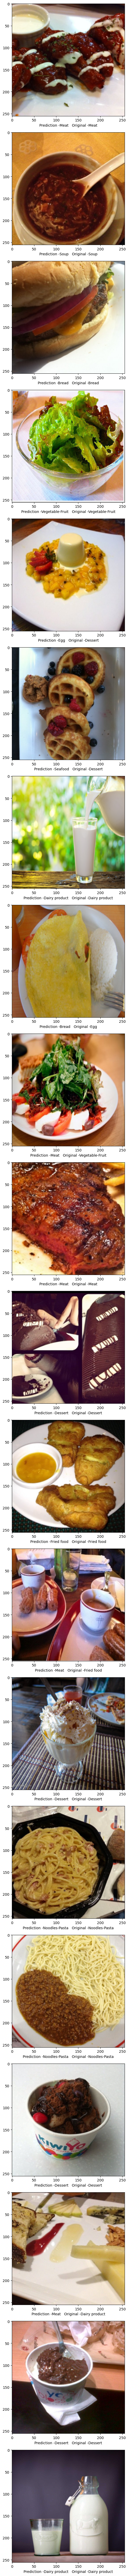

In [ ]:
# Visualizing the results
fig=plt.figure(figsize = (100,100))
for i in range(20):
    j = random.randint(0,len(image))
    fig.add_subplot(20,1,i+1)
    plt.xlabel("Prediction -" + prediction[j] +"   Original -" + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

In [ ]:
# Setelah training, menyimpan model ke dalam file
model.save("model_tf.h5")
print("Model berhasil disimpan.")

Model berhasil disimpan.
